<a href="https://colab.research.google.com/github/simonezambonim/codenation_data_science_desafios/blob/master/Projeto_Final/Content_base_Recommender_HEOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install distython

  Created wheel for gower: filename=gower-0.0.5-cp36-none-any.whl size=4232 sha256=0260f9859272938a8601b2d116396882d2ff5d666ff4c3415869000afacc9b1c
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


# Content-based recommender

The idea of this project is to use create a content-based recommender to recommend leads to companies that are willing to conquer new customers!

The user historic is its list of customers, based on that we mesuare distances among companies in a market database in order to search for similarities to the ones the customer already owns!

An unconventional metric to compare similarities in mixed data types was used.

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise
from sklearn.neighbors import DistanceMetric
from distython import HEOM
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric

In [0]:
def get_info(df):
    '''
    Get basic info from data set
    '''
    print('Shape :: ', df.shape)
    return pd.DataFrame({'types': df.dtypes,
                            'nan': df.isna().sum(), 
                            'nan%': ((df.isna().sum()/len(df))*100).round(1), 
                            'unique':df.nunique()
                            })

In [0]:
def dropna_cols(df,info,max_na): 
    '''
    Function to drop columns above threshold max_na
    '''
    return df.drop(info[info['nan%']  > max_na].index, axis=1).copy()

In [0]:
def categorical_types(df):
    '''
    Our model requires to know where are the positions of each categorical variable
    Here we extract this info!

    returns
    : all_features - complete set of columns
    : categ_features -  boolean and object features 
    : num_features - numeric features
    : categ_bool - the whole index of columns stating True for categorical variables
    '''
    
    all_features = df.columns.to_list()
      
    categ_features = df.select_dtypes(['bool','object']).columns.to_list()
    num_features = df.select_dtypes(['int64','float']).columns.to_list()

    categ_loc = [df.columns.get_loc(x) for x in categ_features]
    categ_func = lambda x: True if x in categ_features else False
    categ_bool = [categ_func(x) for x in all_features]
    categ_idx = dict(zip(categ_features, categ_bool))

    print(f'{df.shape} \n\nNum:{num_features} \n\nCateg: {categ_features}')
    
    return (all_features,categ_features,num_features,categ_bool)

In [0]:
def model_metrics(leads, user_companies):
    '''
    Evaluate the model according to precision
    '''
    TP = sum(leads['id'].isin(user_companies.id))  
    FP = user_companies.shape[0] -TP
    precision = 100*TP/(TP + FP)
    
    print(f'Precision :: {precision:.2f}%')
    return precision

Load data

In [0]:

df_raw = pd.read_csv('/content/drive/My Drive/codenation/estaticos_market.csv', index_col =0)
df1 = pd.read_csv('/content/drive/My Drive/codenation/estaticos_portfolio1.csv',index_col =0)
df2 = pd.read_csv('/content/drive/My Drive/codenation/estaticos_portfolio2.csv',index_col =0)
df3 = pd.read_csv('/content/drive/My Drive/codenation/estaticos_portfolio3.csv',index_col =0)

In [9]:
infoDB = get_info(df_raw)

Shape ::  (462298, 181)


Drop rows with relevant data missing! 

In [11]:
max_percentual_na = 40
df = dropna_cols(df_raw,infoDB,max_percentual_na).copy()
print('Number of cols dropped', (df_raw.shape[1] - df.shape[1]))

## delete companies without 'setor',  'nm_divisao', 'nm_segmento'
print('Numero de empresas sem informações básicas (setor, nm_divisao, nm_segmento)',
df.loc[df.setor.isna(),['setor','de_ramo', 'nm_divisao', 'nm_segmento']].shape[0])

df.dropna(subset = ['setor',  'nm_divisao', 'nm_segmento'], axis = 0, inplace = True)

Numero de empresas sem informações básicas (setor, nm_divisao, nm_segmento) 1927
N cols to drop 15


Drop columns that don`t bring much information, or are already represented in another feature

In [0]:
to_drop_age = ['idade_empresa_anos', 'dt_situacao']
to_drop_rescencia = ['nu_meses_rescencia']
to_drop_idade = ['qt_socios', 'idade_maxima_socios', 'idade_minima_socios']
to_drop_natureza = ['fl_optante_simei', 'fl_optante_simples']
to_drop_faturamento = ['vl_faturamento_estimado_aux','vl_faturamento_estimado_grupo_aux']
to_drop_extra = [ 'fl_email','fl_telefone','sg_uf_matriz']
temp = ['empsetorcensitariofaixarendapopulacao', 'idade_media_socios']

to_drop = to_drop_age + to_drop_rescencia + to_drop_idade + to_drop_natureza + to_drop_faturamento + to_drop_extra + temp
df.drop(columns = to_drop, inplace=True)

print('Number of cols dropped', len(to_drop))

Besides selecting features (as we did) the only procedure needed is to label encode all the categorical variables1

Also fill NaN values with an indicator, in this case we used '-1'.

In [19]:
features, categ_features, num_features, categ_bool = categorical_types(df)

## Here we state the index that correspond to categorical features (exclude 'id')
categorical_ix = [df.columns.get_loc(x) for x in categ_features[1:]]

#We also need to declare a value wich will be the representative number of NaN
nan_eqv = -1

# Let's encode all variables
df_encoded = df.copy()

map_categories = dict()
for feat in categ_features[1:]:
    df_encoded[feat] = df_encoded[feat].astype('category')
    encode_categ = df_encoded[feat].cat.codes
    map_categories[feat] = dict(zip(encode_categ, df_encoded[feat]))
    df_encoded[feat] = encode_categ

# fill with the indicator fo NaN
df_encoded = df_encoded.fillna(nan_eqv)
df_encoded_data = df_encoded.iloc[:,1:].values

(460371, 35) 

Num:['vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo', 'qt_socios_pf', 'qt_socios_pj', 'qt_socios_st_regular', 'qt_filiais'] 

Categ: ['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda', 'fl_st_especial', 'fl_rm', 'nm_divisao', 'nm_segmento', 'fl_spa', 'fl_antt', 'fl_veiculo', 'de_saude_tributaria', 'de_saude_rescencia', 'de_nivel_atividade', 'fl_simples_irregular', 'nm_meso_regiao', 'nm_micro_regiao', 'fl_passivel_iss', 'de_faixa_faturamento_estimado', 'de_faixa_faturamento_estimado_grupo']


In [15]:
df_info = get_info(df_encoded)
df_info[df_info['nan']!=0]

Shape ::  (460371, 35)


,types,nan,nan%,unique


Let's test on dataset 3!

In [0]:
user = df3

user_companies = pd.merge(user[['id']], df_encoded, on='id', how='inner')

all_companies = list(df['id'].unique())
companies_train, companies_test = train_test_split(user_companies, test_size=0.3)
companies_train_data = companies_train.iloc[:,1:].values

Time to find the similarities!

This metric was elaborated by [Wilson and Martinez, 1997](https://arxiv.org/pdf/cs/9701101.pdf)
The implementation was done by Kacper Kubara, and it can be intalled using:

!pip install distython

More info about his work can be found [here](https://towardsdatascience.com/distython-5de10f342c93).

The advantages of this metric is that it can measure similarity among different data types (numerical and categorical - include nominal, ordinal and boolean) in a easy way . 
It does not require any hard work to encode or impute missing values, and can be used very easily with sklearn. 

Here I've applied HEOM -  Heterogeneous Euclidean-Overlap Metric




> *One way to handle applications with both continuous and nominal attributes is to use a
heterogeneous distance function that uses different attribute distance functions on different
kinds of attributes. One approach that has been used is to use the overlap metric for nominal
attributes and normalized Euclidean distance for linear attributes.*

Check out the paper for more details!

In [0]:
# Declare the HEOM with a correct NaN equivalent value
heom_metric = HEOM(df_encoded_data, categorical_ix, nan_equivalents = [nan_eqv]) 

#Calculate the distance Matrix
dist_func = DistanceMetric.get_metric('pyfunc', func = heom_metric.heom)
dist_matrix = dist_func.pairwise(df_encoded_data, companies_train_data)

pickle.dump(dist_matrix, open("HEOM_dist.pkl", "wb"))

Since it took some hours t run, let's make sure se save the distance matrix!

# Show time!

Let's find out who are our leads based on the user historic clients!

In [121]:
# Hyperparameters that define precision
k = 10*len(companies_train) #  list size (the larger, the more likely one of the dataset companies to be in the recommended list)
n_neighbors = 10*len(companies_train) # number of nearby companies to be considered ''in the rating''

ind = []
for i in range(len((companies_train.id))):
   ind_aux = np.argpartition(dist_matrix[:,i], n_neighbors, axis=-1)[:n_neighbors]
   ind.append(ind_aux)
              
 ## Check for reapeted recomendation and count
(unique, counts) = np.unique(np.asarray(ind), return_counts=True)

Precision :: 57.50%


## Time to evaluate and score

In [0]:
# We consider [neighbors] companies close to each company in the portifio
# We think that the norm of the vector of the distance of these candidates companies 
# represents well the distance to all the portfolio  
# Besides that, to account for companies that are close to many companies we multiply a factor
# (1/n_times)**2 where  n_times is the k times it was among the [n_neighbors] candidates
# This factor gives "more weight" to companies that have been constantly present .
# By more weight we mean "reducing" the distance.

relevance = []
for i,n in zip(unique,counts):
    rating = ((1/n)**2)*np.linalg.norm(dist_matrix[i,:]) 
    relevance.append([i, rating])

## Let's sort the best candidates em get the k best candidates
best_candidates = sorted(relevance, key=lambda x: x[1])

 # Retrieving the indexes
top_index = []
for idx,val in best_candidates: 
    top_index.append(idx)

leads = df.iloc[top_index[:k],:]

precision = model_metrics(leads, companies_test)

Let's see who are the recommended leads!

In [124]:
leads.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,de_saude_tributaria,de_saude_rescencia,de_nivel_atividade,fl_simples_irregular,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios_pf,qt_socios_pj,qt_socios_st_regular,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo,qt_filiais
337860,2c934243c09283d5b34f2a17cae401c9902b63a50ab051...,True,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,AC,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,False,False,False,False,False,False,NAO,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,False,False,True,0.0,1.0,VERDE,ACIMA DE 1 ANO,ALTA,False,VALE DO ACRE,RIO BRANCO,True,NaN,NaN,NaN,"DE R$ 30.000.000,01 A R$ 100.000.000,00","DE R$ 30.000.000,01 A R$ 100.000.000,00",0
146603,edcefa7f000dff8be1ba3d51b6f259e5971f7df7423b2f...,True,AUTARQUIA ESTADUAL OU DO DISTRITO FEDERAL,RO,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,False,False,False,False,False,False,NAO,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,False,False,True,0.0,10.0,VERDE,ACIMA DE 1 ANO,ALTA,False,NaN,NaN,True,NaN,NaN,NaN,"DE R$ 30.000.000,01 A R$ 100.000.000,00","DE R$ 30.000.000,01 A R$ 100.000.000,00",0
436688,e0b119d56503e6e67907b5525816c8e43b3807a09f02eb...,True,ORGAO PUBLICO DO PODER EXECUTIVO ESTADUAL OU D...,PI,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,False,False,False,False,False,False,SIM,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,False,False,True,0.0,5.0,VERDE,ACIMA DE 1 ANO,ALTA,False,CENTRO NORTE PIAUIENSE,TERESINA,True,NaN,NaN,NaN,"DE R$ 10.000.000,01 A R$ 30.000.000,00","DE R$ 10.000.000,01 A R$ 30.000.000,00",0
72552,72793ebb92ba8c1a7d15831ae143db93d62f555f67248a...,True,ORGAO PUBLICO DO PODER LEGISLATIVO ESTADUAL OU...,PI,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,False,False,False,False,False,False,SIM,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,False,False,True,0.0,14.0,VERDE,ACIMA DE 1 ANO,ALTA,False,CENTRO NORTE PIAUIENSE,TERESINA,True,NaN,NaN,NaN,"DE R$ 100.000.000,01 A R$ 300.000.000,00","DE R$ 100.000.000,01 A R$ 300.000.000,00",0
200126,fc3daa8a071d8eed776ad6111621835b527d42980e340d...,True,AUTARQUIA FEDERAL,PI,ADMINISTRACAO PUBLICA,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,> 20,False,False,False,False,False,False,SIM,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,ADMINISTRACAO PUBLICA DEFESA E SEGURIDADE SOCIAL,False,False,True,0.0,4.0,AZUL,ACIMA DE 1 ANO,ALTA,False,CENTRO NORTE PIAUIENSE,TERESINA,True,NaN,NaN,NaN,"DE R$ 1.500.000,01 A R$ 4.800.000,00","DE R$ 1.500.000,01 A R$ 4.800.000,00",0


In [0]:
import plotly.express as px
px.defaults.width = 1000
px.defaults.height = 500

Understanding the user's customers according to ['setor', 'de_ramo', 'nm_segmento'].

In [152]:
cols = ['setor', 'de_ramo', 'nm_segmento']
value = 'qt_filiais'

px.parallel_categories( pd.merge(user[['id']], df, on='id', how='inner'), 
                       dimensions = cols,
                        color=value, 
                       color_continuous_scale=px.colors.sequential.Inferno)

Now lest's evaluate the recommended leads by ['setor', 'de_ramo', 'nm_segmento'].

In [151]:
cols = ['setor', 'de_ramo', 'nm_segmento']
value = 'qt_filiais'

px.parallel_categories(leads, dimensions = cols,
                        color=value, 
                       color_continuous_scale=px.colors.sequential.Inferno)

In fact our model has identified its main market, however it's not proportional to the user's customers. 

In [163]:
leads_aux = df.copy()
leads_aux['root'] = 'root'#.insert(0,cte_tag,cte_tag)
values = ['idade_emp_cat']

px.treemap(leads_aux, path=(cols.insert(0,'root')), values=values[0],
                  hover_data=[values[0]])

TypeError: ignored

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid",font_scale=0.6)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



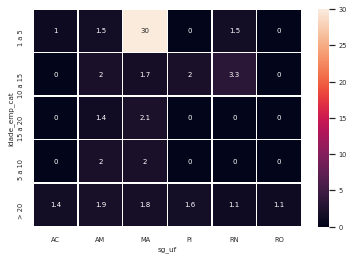

In [162]:
cols = ['idade_emp_cat', 'sg_uf', 'qt_socios_pf']
func = np.mean
sns.heatmap(leads.pivot_table(index =cols[0], columns =cols[1],  values =cols[2], aggfunc=func, fill_value=0).dropna(axis=1), annot=True, annot_kws={"size": 7}, linewidths=.5)

The aim of using this metric was to understand how it would perform comparered to Gower coefficient simillarity (another composite metric)!
As we can see, without any imputation, any encode or trnsforming (only the regular label encoding for all categorical), this metric performs quite well! 
We can notice that the work to use this metric is very low! And as we increase the parameter 'n_neighbors' we can get better estimates!

However, the drawback of this metric is that it takes a long time to get the distance matrix, that's the reason why we didn't test it with the other datasets.

# Future developments!

- Create weights for features  according to user historic data (evaluate low variance - meaning it is a feature that represents well its profile)!
- Evaluate the same metric without missing values (perform inputation)

